In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras 
from keras import layers, Model, regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Data Generation


In [5]:

# Generate merchant profiles
def generate_merchants(num_merchants):
    business_types = ['Retail', 'Restaurant', 'E-commerce', 'Services', 'Wholesale']
    gst_status = ['Active', 'Inactive', 'Pending']
    
    # 20% of merchants are fraudulent
    num_fraudulent = int(num_merchants * 0.2)
    is_fraudulent_list = ([True] * num_fraudulent + 
                         [False] * (num_merchants - num_fraudulent))
    random.shuffle(is_fraudulent_list)
    
    merchants = []
    for i, is_fraudulent in enumerate(is_fraudulent_list):
        merchant = {
            'merchant_id': f'M{str(i).zfill(6)}',
            'name': f'Merchant_{i}',
            'business_type': random.choice(business_types),
            'registration_date': datetime.now(),
            'gst_status': random.choice(gst_status),
            'is_fraudulent': is_fraudulent
        }
        merchants.append(merchant)
    return pd.DataFrame(merchants)

# Generate transaction data
def generate_normal_transactions(merchant_id, num_days):
    current_date = datetime.now()
    transactions = []
    
    for _ in range(random.randint(50, 200)):  
        transaction_date = current_date - timedelta(days=random.randint(0, num_days))
        amount = random.normalvariate(1000, 300)  # Normal distribution
        customer_id = f'C{random.randint(1, 1000)}'
        
        transactions.append({
            'merchant_id': merchant_id,
            'transaction_date': transaction_date,
            'amount': max(10, amount),
            'customer_id': customer_id
        })
    return transactions

def generate_fraudulent_transactions(merchant_id, num_days):
    current_date = datetime.now()
    transactions = []
    fraud_type = random.choice(['late_night', 'high_velocity', 'customer_concentration'])
    
    if fraud_type == 'late_night':
        for _ in range(random.randint(20, 50)):
            transaction_date = current_date - timedelta(days=random.randint(0, num_days))
            transaction_date = transaction_date.replace(
                hour=23 if random.random() < 0.5 else random.randint(0, 4), 
                minute=random.randint(0, 59)
            )
            amount = random.normalvariate(2000, 500) # Higher amount transactions
            customer_id = f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
            
    elif fraud_type == 'high_velocity':
        # Generate high velocity spikes
        spike_day = current_date - timedelta(days=random.randint(0, num_days))
        for _ in range(random.randint(150, 250)):
            transaction_date = spike_day + timedelta(hours=random.randint(0, 24))
            amount = random.normalvariate(1500, 400)
            customer_id = f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
            
    else:  # customer_concentration
        # Generate transactions with high customer concentration
        main_customer = f'C{random.randint(1, 100)}'
        for _ in range(random.randint(50, 150)):
            transaction_date = current_date - timedelta(days=random.randint(0, num_days))
            amount = random.normalvariate(1200, 300)
            customer_id = main_customer if random.random() < 0.8 else f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
    
    return transactions


In [6]:
num_merchants = 1000
merchants_df = generate_merchants(num_merchants)

# Generate transactions for each merchant
all_transactions = []
for _, merchant in merchants_df.iterrows():
    if merchant['is_fraudulent']:
        transactions = generate_fraudulent_transactions(merchant['merchant_id'], 30)
    else:
        transactions = generate_normal_transactions(merchant['merchant_id'], 30)
    all_transactions.extend(transactions)

transactions_df = pd.DataFrame(all_transactions)

In [7]:
transactions_df.to_csv('transactions.csv', index=False)
transactions_df.head()

,merchant_id,transaction_date,amount,customer_id
0,M000000,2024-11-06 19:49:45.118419,1409.670397,C6
1,M000000,2024-11-22 19:49:45.118419,716.844777,C570
2,M000000,2024-11-20 19:49:45.118419,1029.741782,C534
3,M000000,2024-11-15 19:49:45.118419,1250.647485,C169
4,M000000,2024-10-28 19:49:45.118419,1012.091253,C443


# Preprocessing



In [8]:

def calculate_merchant_features(transactions_df):
    features = []
    
    for merchant_id in transactions_df['merchant_id'].unique():
        merchant_txns = transactions_df[transactions_df['merchant_id'] == merchant_id]
        
        # Transaction velocity metrics
        daily_txn_counts = merchant_txns.groupby(
            merchant_txns['transaction_date'].dt.date
        ).size().describe()
        # print(merchant_txns.groupby(
        #     merchant_txns['transaction_date'].dt.date
        # ).size().describe())
        
        # Time-based patterns
        hour_distribution = merchant_txns['transaction_date'].dt.hour.value_counts(normalize=True)
        night_hours = [h for h in range(24) if h >= 22 or h <= 4]
        night_txn_ratio = sum(hour_distribution.get(h, 0) for h in night_hours)
        
        # Amount distributions
        amount_stats = merchant_txns['amount'].describe()
        
        # Customer concentration
        customer_concentration = (
            merchant_txns.groupby('customer_id').size().max() / 
            len(merchant_txns)
        )
        
        features.append({
            'merchant_id': merchant_id,
            'avg_daily_txns': daily_txn_counts['mean'],
            'max_daily_txns': daily_txn_counts['max'],
            'min_daily_txns': daily_txn_counts['min'],
            'std_daily_txns': daily_txn_counts['std'],
            'night_txn_ratio': night_txn_ratio,
            'avg_amount': amount_stats['mean'],
            'std_amount': amount_stats['std'],
            'min_amount': amount_stats['min'],
            'max_amount': amount_stats['max'],
            'customer_concentration': customer_concentration

        })
        # break
    
    return pd.DataFrame(features)


In [9]:
features_df = calculate_merchant_features(transactions_df)
feature_columns = features_df.columns.difference(['merchant_id'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_df[feature_columns])


In [10]:
pd.DataFrame(normalized_features, columns=feature_columns).head()

,avg_amount,avg_daily_txns,customer_concentration,max_amount,max_daily_txns,min_amount,min_daily_txns,night_txn_ratio,std_amount,std_daily_txns
0,-0.387420,-0.208532,-0.281081,-0.194779,-0.230742,-0.691399,-0.165414,-0.336330,-0.516980,-0.244079
1,2.579584,-0.354456,-0.227166,2.135228,-0.367877,2.470321,-0.271926,3.517339,2.163212,-0.301116
2,0.154217,-0.222525,3.744566,0.108729,-0.148462,0.185744,-0.271926,-0.336330,0.384891,-0.226206
3,2.902769,-0.358696,-0.019850,3.733616,-0.395304,3.464797,-0.271926,3.517339,4.102179,-0.306829
4,-0.448528,-0.200136,-0.316516,-0.311059,-0.148462,-0.128937,-0.271926,-0.336330,-0.187265,-0.215755


In [11]:
len(normalized_features)

1000

# Auto Encoder Model

In [12]:
# Build autoencoder model
input_dim = normalized_features.shape[1]
input_layer = layers.Input(shape=(input_dim,))
# Encoder
encoded = layers.Dense(32, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)
# Decoder
decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:

# Train the model with callbacks
history = autoencoder.fit(
    normalized_features, 
    normalized_features,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1759 - val_loss: 1.1235
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1588 - val_loss: 0.9702
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0017 - val_loss: 0.7194
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7668 - val_loss: 0.5733
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6180 - val_loss: 0.5428
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5973 - val_loss: 0.5260
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6123 - val_loss: 0.5196
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5372 - val_loss: 0.5175
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5743 - val_loss: 0.5164
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5439 - val_loss: 0.5162
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6044 - val_loss: 0.5158
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5

In [21]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,104 (23.85 KB)

 Trainable params: 2,034 (7.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,070 (15.90 KB)

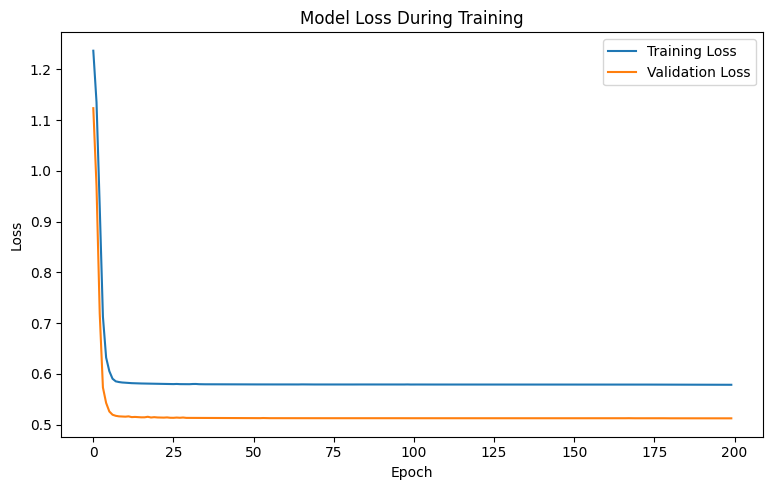

In [15]:

# Plot training history with multiple metrics
plt.figure(figsize=(15, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
reconstructed = autoencoder.predict(normalized_features)
mse = np.mean(np.power(normalized_features - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 90)  # 90th percentile as threshold
anomaly_scores = mse / threshold  # Normalized anomaly scores


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [17]:
def detect_patterns(features_df, anomaly_scores):
    patterns = []
    
    velocity_threshold = 3.0  # Standard deviations above mean
    night_ratio_threshold = 0.3
    concentration_threshold = 0.5
    
    for idx, row in features_df.iterrows():
        merchant_patterns = []
        
        # High velocity detection
        if (row['max_daily_txns'] - row['avg_daily_txns']) / row['std_daily_txns'] > velocity_threshold:
            merchant_patterns.append('high_velocity')
            
        # Odd-hour pattern detection
        if row['night_txn_ratio'] > night_ratio_threshold:
            merchant_patterns.append('odd_hours')
            
        # Customer concentration analysis
        if row['customer_concentration'] > concentration_threshold:
            merchant_patterns.append('customer_concentration')
            
        patterns.append({
            'merchant_id': row['merchant_id'],
            'anomaly_score': anomaly_scores[idx],
            'detected_patterns': merchant_patterns,
            'is_suspicious': anomaly_scores[idx] > 1.0 or len(merchant_patterns) > 0
        })
    
    return pd.DataFrame(patterns)



Suspicious Merchants:
    merchant_id  anomaly_score                        detected_patterns
1       M000001       0.720923                              [odd_hours]
2       M000002       0.408273  [high_velocity, customer_concentration]
3       M000003       1.715461                              [odd_hours]
8       M000008       0.053884                          [high_velocity]
14      M000014       1.479497               [high_velocity, odd_hours]
..          ...            ...                                      ...
984     M000984       2.532131                                       []
988     M000988       3.105676                                       []
990     M000990       0.340779                 [customer_concentration]
992     M000992       0.438650                 [customer_concentration]
999     M000999       0.967148                              [odd_hours]

[275 rows x 3 columns]


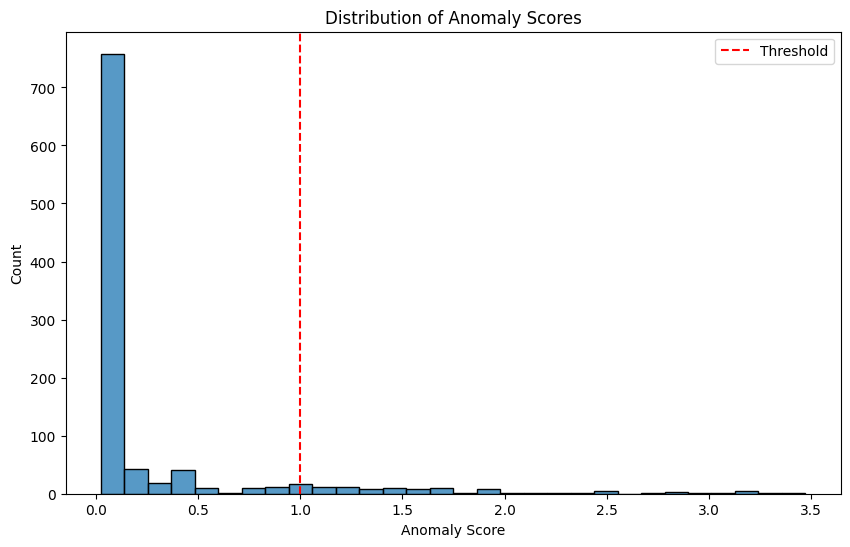

In [18]:

# Detect patterns
results = detect_patterns(features_df, anomaly_scores)

# Display suspicious merchants
suspicious_merchants = results[results['is_suspicious']]
print("\nSuspicious Merchants:")
print(suspicious_merchants[['merchant_id', 'anomaly_score', 'detected_patterns']])

# Plot anomaly score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=results, x='anomaly_score', bins=30)
plt.axvline(x=1.0, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()


In [19]:
# Compare detected fraud with actual fraudulent merchants
results['actual_fraudulent'] = results['merchant_id'].map(
    merchants_df.set_index('merchant_id')['is_fraudulent']
)

# Calculate detection metrics
true_positives = sum((results['is_suspicious']) & (results['actual_fraudulent']))
false_positives = sum((results['is_suspicious']) & (~results['actual_fraudulent']))
false_negatives = sum((~results['is_suspicious']) & (results['actual_fraudulent']))
true_negatives = sum((~results['is_suspicious']) & (~results['actual_fraudulent']))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nDetection Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Detection Metrics:
Precision: 0.70
Recall: 0.96
F1 Score: 0.81


In [22]:
# 30 % of Predicted Frauds are actually not Frauds(Precision)
# Only 4 % of actual Frauds are predicted as not Fraud (Recall)


In [20]:
autoencoder.save('merchant_fraud_detector.h5')


results.to_csv('fraud_detection_results.csv', index=False)